In [0]:
#Authenticate into Google Drive and find file ids in order to read in data files
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [55]:
#https://drive.google.com/file/d/1sL8ooo5l5Z89vi0dLn8zoTz9zfzfl82g/view?usp=sharing
# 2. Load files by ID and print its contents.

file_id = '1sL8ooo5l5Z89vi0dLn8zoTz9zfzfl82g' #Link Share the file and copy the id in the url after "id="
file = drive.CreateFile({'id': file_id}) #This creates a file in your virtual machine
file.GetContentFile('boston.csv') #This names the file you linked in drive "survey.csv"
!ls -lha #This lists all the folder in your local folder, you should see "survey.csv"

total 108K
drwxr-xr-x 1 root root 4.0K Jul 21 12:46 .
drwxr-xr-x 1 root root 4.0K Jul 21 12:04 ..
-rw-r--r-- 1 root root  36K Jul 21 14:33 boston.csv
drwx------ 4 root root 4.0K Jul 21 12:37 .cache
drwxr-xr-x 3 root root 4.0K Jul 21 12:37 .config
-rw-r--r-- 1 root root  407 Jul 21 12:46 cv-results-df-mean.txt
drwxr-xr-x 1 root root 4.0K Jul 21 12:46 datalab
drwxr-xr-x 4 root root 4.0K Jul 21 12:05 .forever
drwxr-xr-x 5 root root 4.0K Jul 21 12:37 .ipython
drwx------ 3 root root 4.0K Jul 21 12:05 .local
-rw-r--r-- 1 root root  25K Jul 21 12:46 plot-corr-map.pdf


In [0]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from math import sqrt 

get_ipython().magic(u'matplotlib inline')
#these are some options to control output on your screen 
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 40) 
pd.set_option('display.max_rows', 50) 
pd.set_option('display.width', 120)

In [0]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1
SET_FIT_INTERCEPT = True

In [0]:
boston = pd.read_csv('boston.csv')

**Begin EDA**

In [168]:
print('')
print('----- Summary of Input Data -----')
print('')

# show the object is a DataFrame
print('Object type: ', type(boston))
print('')
# show number of observations in the DataFrame
print('Number of observations: ', len(boston))
print('')
# show variable names
print('Variable names: ', boston.columns)


----- Summary of Input Data -----

('Object type: ', <class 'pandas.core.frame.DataFrame'>)

('Number of observations: ', 506)

('Variable names: ', Index([u'crim', u'zn', u'indus', u'chas', u'nox', u'rooms', u'age', u'dis', u'rad', u'tax', u'ptratio', u'lstat',
       u'mv'],
      dtype='object'))


In [169]:
#show variable names, observations for each, data type for each
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rooms      506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
lstat      506 non-null float64
mv         506 non-null float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [170]:
# How many Null values?
len(boston.index)-boston.count()

crim       0
zn         0
indus      0
chas       0
nox        0
rooms      0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
mv         0
dtype: int64

In [171]:
boston.describe()

            crim         zn      indus       chas        nox      rooms        age        dis        rad        tax  \
count  506.00000  506.00000  506.00000  506.00000  506.00000  506.00000  506.00000  506.00000  506.00000  506.00000   
mean     3.61352   11.36364   11.13678    0.06917    0.55470    6.28463   68.57490    3.79504    9.54941  408.23715   
std      8.60155   23.32245    6.86035    0.25399    0.11588    0.70262   28.14886    2.10571    8.70726  168.53712   
min      0.00632    0.00000    0.46000    0.00000    0.38500    3.56100    2.90000    1.12960    1.00000  187.00000   
25%      0.08204    0.00000    5.19000    0.00000    0.44900    5.88550   45.02500    2.10018    4.00000  279.00000   
50%      0.25651    0.00000    9.69000    0.00000    0.53800    6.20850   77.50000    3.20745    5.00000  330.00000   
75%      3.67708   12.50000   18.10000    0.00000    0.62400    6.62350   94.07500    5.18843   24.00000  666.00000   
max     88.97620  100.00000   27.74000    1.0000

In [172]:
boston.head()

      crim    zn  indus  chas    nox  rooms   age     dis  rad  tax  ptratio  lstat    mv
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   4.98  24.0
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   9.14  21.6
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   4.03  34.7
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   2.94  33.4
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   5.33  36.2

In [173]:
boston.tail()

        crim   zn  indus  chas    nox  rooms   age     dis  rad  tax  ptratio  lstat    mv
501  0.06263  0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273     21.0   9.67  22.4
502  0.04527  0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273     21.0   9.08  20.6
503  0.06076  0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273     21.0   5.64  23.9
504  0.10959  0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273     21.0   6.48  22.0
505  0.04741  0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273     21.0   7.88  19.0

In [174]:
##drop neighborhood because it says so
boston = boston.drop('neighborhood', 1)

ValueError: ignored

In [0]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

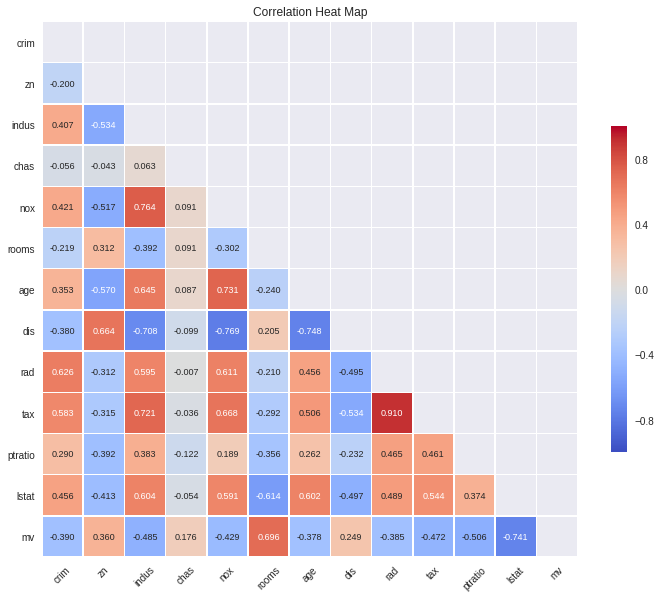

In [176]:
# examine intercorrelations
# with correlation matrix/heat map
corr_chart(df_corr = boston)

In [0]:
corr_matrix = boston.corr()

In [178]:
corr_matrix["mv"].sort_values(ascending=False)

mv         1.00000
rooms      0.69630
zn         0.36039
dis        0.24931
chas       0.17566
age       -0.37800
rad       -0.38477
crim      -0.38958
nox       -0.42930
tax       -0.47198
indus     -0.48475
ptratio   -0.50565
lstat     -0.74084
Name: mv, dtype: float64

**Begin Modeling**

In [179]:
# set up preliminary data for data for fitting the models 
# the first column is the median housing value response
# the remaining columns are the explanatory variables
prelim_model_data = np.array([boston.mv,\
    boston.crim,\
    boston.zn,\
    boston.indus,\
    boston.chas,\
    boston.nox,\
    boston.rooms,\
    boston.age,\
    boston.dis,\
    boston.rad,\
    boston.tax,\
    boston.ptratio,\
    boston.lstat]).T

# dimensions of the polynomial model X input and y response
# preliminary data before standardization
print('\nData dimensions:', prelim_model_data.shape)

# standard scores for the columns... along axis 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(prelim_model_data))
# show standardization constants being employed
print(scaler.mean_)
print(scaler.scale_)

# the model data will be standardized form of preliminary model data
model_data = scaler.fit_transform(prelim_model_data)

# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print('\nDimensions for model_data:', model_data.shape)



('\nData dimensions:', (506, 13))
StandardScaler(copy=True, with_mean=True, with_std=True)
[2.25288538e+01 3.61352356e+00 1.13636364e+01 1.11367787e+01
 6.91699605e-02 5.54695059e-01 6.28463439e+00 6.85749012e+01
 3.79504269e+00 9.54940711e+00 4.08237154e+02 1.84555336e+01
 1.26530632e+01]
[9.17309810e+00 8.59304135e+00 2.32993957e+01 6.85357058e+00
 2.53742935e-01 1.15763115e-01 7.01922514e-01 2.81210326e+01
 2.10362836e+00 8.69865112e+00 1.68370495e+02 2.16280519e+00
 7.13400164e+00]
('\nDimensions for model_data:', (506, 13))


In [0]:
names = ["Linear", "Ridge", "Lasso", "Elastic Net", "Ridge_1", "Lasso_1", "Elastic Net_1", "Ridge_.5", "Lasso_.5", "Elastic Net_.5"]
regressions = [LinearRegression(fit_intercept = SET_FIT_INTERCEPT), 
              Ridge(alpha=0.1, 
                    solver="cholesky", 
                    fit_intercept = SET_FIT_INTERCEPT,
                   random_state = RANDOM_SEED), 
              Lasso(alpha=0.1, 
                    fit_intercept = SET_FIT_INTERCEPT,
                   random_state = RANDOM_SEED), 
              ElasticNet(alpha=0.1, 
                         l1_ratio=0.5, 
                         fit_intercept = SET_FIT_INTERCEPT,
                        random_state = RANDOM_SEED), 
              Ridge(alpha=1, 
                    solver="cholesky", 
                    fit_intercept = SET_FIT_INTERCEPT,
                   random_state = RANDOM_SEED), 
              Lasso(alpha=1, 
                    fit_intercept = SET_FIT_INTERCEPT,
                   random_state = RANDOM_SEED), 
              ElasticNet(alpha=1, 
                         l1_ratio=0.5, 
                         fit_intercept = SET_FIT_INTERCEPT,
                        random_state = RANDOM_SEED), 
              Ridge(alpha=0.5, 
                    solver="cholesky", 
                    fit_intercept = SET_FIT_INTERCEPT,
                   random_state = RANDOM_SEED), 
              Lasso(alpha=0.5, 
                    fit_intercept = SET_FIT_INTERCEPT,
                   random_state = RANDOM_SEED), 
              ElasticNet(alpha=0.5, 
                         l1_ratio=0.5, 
                         fit_intercept = SET_FIT_INTERCEPT,
                        random_state = RANDOM_SEED)]

In [0]:
# ten-fold cross-validation employed here
N_FOLDS = 10

In [0]:
# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

In [183]:
# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable    
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, lin_model in zip(names, regressions):
        print('\nRegression evaluation for:', name)
        print('  Scikit Learn method:', lin_model)
        lin_model.fit(X_train, y_train)  # fit on the train set for this fold
        print('Fitted regression intercept:', lin_model.intercept_)
        print('Fitted regression coefficients:', lin_model.coef_)
        # evaluate on the test set for this fold
        y_test_predict = lin_model.predict(X_test)
        print('Coefficient of determination (R-squared):',
              r2_score(y_test, y_test_predict))
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        print(lin_model.get_params(deep=True))
        print('Root mean-squared error:', fold_method_result,
              '\n--------------------------------------------------------\n')
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1

('\nFold index:', 0, '------------------------------------------')
('\nShape of input data for this fold:', '\nData Set: (Observations, Variables)')
('X_train:', (455, 12))
('X_test:', (51, 12))
('y_train:', (455,))
('y_test:', (51,))
('\nRegression evaluation for:', 'Linear')
('  Scikit Learn method:', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))
('Fitted regression intercept:', -0.005032049293645771)
('Fitted regression coefficients:', array([-0.11088775,  0.13573238,  0.01408652,  0.0787664 , -0.23758124,
        0.26794267,  0.0065031 , -0.37082275,  0.27035218, -0.23150162,
       -0.21456859, -0.45500336]))
('Coefficient of determination (R-squared):', 0.7650752349379011)
{'copy_X': True, 'normalize': False, 'n_jobs': 1, 'fit_intercept': True}
('Root mean-squared error:', 0.3080338355432654, '\n--------------------------------------------------------\n')
('\nRegression evaluation for:', 'Ridge')
('  Scikit Learn method:', Ridge(alpha=0.1, copy_X=T

{'normalize': False, 'warm_start': False, 'selection': 'cyclic', 'fit_intercept': True, 'positive': False, 'max_iter': 1000, 'precompute': False, 'random_state': 1, 'tol': 0.0001, 'copy_X': True, 'alpha': 0.1}
('Root mean-squared error:', 1.3042238563675213, '\n--------------------------------------------------------\n')
('\nRegression evaluation for:', 'Elastic Net')
('  Scikit Learn method:', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1, selection='cyclic', tol=0.0001, warm_start=False))
('Fitted regression intercept:', -0.03378560937748078)
('Fitted regression coefficients:', array([-0.        ,  0.        , -0.        ,  0.        , -0.02671125,
        0.48988645, -0.        , -0.        , -0.        , -0.11932863,
       -0.16606774, -0.21411406]))
('Coefficient of determination (R-squared):', 0.01287993497346629)
{'normalize': False, 'warm_start': False, 'selectio

In [0]:
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

In [185]:
pd.set_option('precision', 5)
print('Root Mean Squared Errors\n----------------------------------------------')
#print('Average results from ', N_FOLDS, '-fold cross-validation\n',
#      'in standardized units (mean 0, standard deviation 1)\n',
#      '\nMethod Root mean-squared error', sep = '') 
print(cv_results_df.mean())   
with open("cv-results-df-mean.txt", "w") as text_file:
    text_file.write('\nAverage results from '+ str(N_FOLDS) + '-fold cross-validation\n'+
                    'in standardized units (mean 0, standard deviation 1)\n'+
                     '\nMethod Root mean-squared error:\n'+ 
                     str(cv_results_df.mean()))

Root Mean Squared Errors
----------------------------------------------
Linear            0.56194
Ridge             0.56179
Lasso             0.58697
Elastic Net       0.56845
Ridge_1           0.56051
Lasso_1           0.96809
Elastic Net_1     0.85004
Ridge_.5          0.56121
Lasso_.5          0.83038
Elastic Net_.5    0.67567
dtype: float64


Ridge with alpha of 1 performed the best, based on the lowest RMSE. Now lets use the unstandardized dataset and run through the same algorithm

In [186]:
boston.columns

Index([u'crim', u'zn', u'indus', u'chas', u'nox', u'rooms', u'age', u'dis', u'rad', u'tax', u'ptratio', u'lstat',
       u'mv'],
      dtype='object')

In [0]:
#X=boston[['mv','crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']]
#y=boston[['mv']]

In [0]:
#|X.columns
#X_train, X_test, y_train, y_test = train_test_split(
#...     X, y, test_size=0.33, random_state=42)

In [189]:
# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(prelim_model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable    
    X_train = prelim_model_data[train_index, 1:prelim_model_data.shape[1]]
    X_test = prelim_model_data[test_index, 1:prelim_model_data.shape[1]]
    y_train = prelim_model_data[train_index, 0]
    y_test = prelim_model_data[test_index, 0]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, lin_model in zip(names, regressions):
        print('\nRegression evaluation for:', name)
        print('  Scikit Learn method:', lin_model)
        lin_model.fit(X_train, y_train)  # fit on the train set for this fold
        print('Fitted regression intercept:', lin_model.intercept_)
        print('Fitted regression coefficients:', lin_model.coef_)
        # evaluate on the test set for this fold
        y_test_predict = lin_model.predict(X_test)
        print('Coefficient of determination (R-squared):',
              r2_score(y_test, y_test_predict))
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        print(lin_model.get_params(deep=True))
        print('Root mean-squared error:', fold_method_result,
              '\n--------------------------------------------------------\n')
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1

('\nFold index:', 0, '------------------------------------------')
('\nShape of input data for this fold:', '\nData Set: (Observations, Variables)')
('X_train:', (455, 12))
('X_test:', (51, 12))
('y_train:', (455,))
('y_test:', (51,))
('\nRegression evaluation for:', 'Linear')
('  Scikit Learn method:', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))
('Fitted regression intercept:', 42.94831053147826)
('Fitted regression coefficients:', array([-1.18373016e-01,  5.34385738e-02,  1.88539674e-02,  2.84749568e+00,
       -1.88259963e+01,  3.50161780e+00,  2.12131600e-03, -1.61701255e+00,
        2.85097890e-01, -1.26125846e-02, -9.10049014e-01, -5.85056003e-01]))
('Coefficient of determination (R-squared):', 0.7650752349379002)
{'copy_X': True, 'normalize': False, 'n_jobs': 1, 'fit_intercept': True}
('Root mean-squared error:', 2.8256245911114384, '\n--------------------------------------------------------\n')
('\nRegression evaluation for:', 'Ridge')
('  Scik

('Coefficient of determination (R-squared):', 0.4012157455545784)
{'normalize': False, 'fit_intercept': True, 'max_iter': None, 'random_state': 1, 'tol': 0.001, 'copy_X': True, 'alpha': 0.5, 'solver': 'cholesky'}
('Root mean-squared error:', 3.0952166387368423, '\n--------------------------------------------------------\n')
('\nRegression evaluation for:', 'Lasso_.5')
('  Scikit Learn method:', Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))
('Fitted regression intercept:', 38.548103789654036)
('Fitted regression coefficients:', array([-0.09322967,  0.04588504, -0.03916186,  0.        , -0.        ,
        2.1855214 ,  0.00319365, -0.99831153,  0.25193063, -0.01658924,
       -0.66564314, -0.71278269]))
('Coefficient of determination (R-squared):', 0.19096397165124035)
{'normalize': False, 'warm_start': False, 'selection': 'cyclic', 'fit_intercep

In [0]:
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

In [191]:
pd.set_option('precision', 5)
print('Root Mean Squared Errors\n----------------------------------------------')
#print('Average results from ', N_FOLDS, '-fold cross-validation\n',
#      'in standardized units (mean 0, standard deviation 1)\n',
#      '\nMethod Root mean-squared error', sep = '') 
print(cv_results_df.mean())   
with open("cv-results-df-mean.txt", "w") as text_file:
    text_file.write('\nAverage results from '+ str(N_FOLDS) + '-fold cross-validation\n'+
                    'in standardized units (mean 0, standard deviation 1)\n'+
                     '\nMethod Root mean-squared error:\n'+ 
                     str(cv_results_df.mean()))

Root Mean Squared Errors
----------------------------------------------
Linear            5.15473
Ridge             5.13838
Lasso             5.13338
Elastic Net       5.08043
Ridge_1           5.08482
Lasso_1           5.52316
Elastic Net_1     5.28702
Ridge_.5          5.10195
Lasso_.5          5.25595
Elastic Net_.5    5.15085
dtype: float64


In [0]:
#With out standardized obseervaitons Elastic Net with .1 has the smallest RMSE.
#lets look at just that one

In [0]:
X=boston[['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']]
y=boston[['mv']]

In [0]:
elastic_net=ElasticNet(alpha=0.1, 
                         l1_ratio=0.5, 
                         fit_intercept = SET_FIT_INTERCEPT,
                        random_state = RANDOM_SEED)

In [194]:
elastic_net.fit(X,y)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

In [195]:
elastic_net.coef_

array([-0.11216605,  0.05318999, -0.05372293,  1.07483501, -0.11746863,
        3.10897999, -0.00518971, -1.20704105,  0.2663905 , -0.01578661,
       -0.73847995, -0.63244652])

In [196]:
elastic_net.intercept_

array([33.84893839])

# **Random Forest**

In [197]:
X.columns


Index([u'crim', u'zn', u'indus', u'chas', u'nox', u'rooms', u'age', u'dis', u'rad', u'tax', u'ptratio', u'lstat'], dtype='object')

In [198]:
y.columns

Index([u'mv'], dtype='object')

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [0]:
tree=DecisionTreeRegressor().fit(X_train,y_train)

In [202]:
tree.score(X_test, y_test)

0.7953293268603279

In [203]:
#‘neg_mean_squared_error’
scores = cross_val_score(tree, X, y, cv=10, scoring='neg_mean_squared_error')
scores

array([ -16.80156863,   -9.58176471,  -15.73980392,  -92.03745098,
        -22.9172549 ,  -34.50078431,  -14.448     , -114.4944    ,
        -64.5972    ,  -19.0966    ])

In [204]:
r_scores=np.sqrt(np.abs(scores))
r_scores

array([ 4.09897165,  3.09544257,  3.96734217,  9.59361512,  4.78719698,
        5.87373683,  3.80105249, 10.70020561,  8.03723833,  4.36996567])

In [205]:
np.mean(r_scores)

5.832476741648465

In [0]:
#Look at the decisions tree
from sklearn.tree import export_graphviz

In [0]:
export_graphviz(tree, out_file="tree.dot")

In [0]:
!pip install graphviz
!apt-get install graphviz

In [0]:
import graphviz

In [0]:
with open("tree.dot") as f:
  dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [0]:
#feature importance
def plot_feature_importance(model):
  n_features = X.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), X.columns)
  plt.xlabel("Feature Importance")
  plt.ylabel("Feature")
  plt.ylim(-1, n_features)

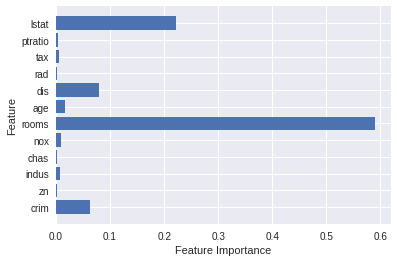

In [134]:
plot_feature_importance(tree)

In [210]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf_house = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf_house.fit(X_train, y_train);

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [211]:
rf_house.score(X_test, y_test)

0.8640824148289223

In [212]:
#‘neg_mean_squared_error’
rf_scores = cross_val_score(rf_house, X, y, cv=10, scoring='neg_mean_squared_error')
rf_scores

array([ -9.95273149,  -4.96701465,  -5.89277737, -20.74840668,
       -10.33533543, -21.56311999,  -7.3729665 , -89.16059799,
       -29.62866248, -12.75217339])

In [213]:
rf_scores=np.sqrt(np.abs(rf_scores))
rf_scores

array([3.154795  , 2.22868002, 2.42750435, 4.5550419 , 3.21486165,
       4.64361066, 2.7153207 , 9.44248897, 5.4432217 , 3.57101854])

In [214]:
np.mean(rf_scores)

4.139654349275048

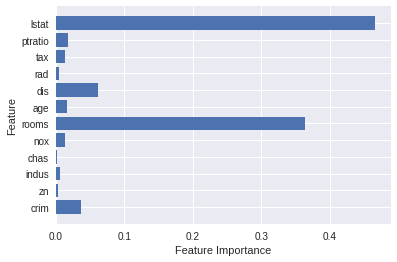

In [215]:
plot_feature_importance(rf_house)

In [0]:
##lets find some optimal paramaters
from sklearn.model_selection import GridSearchCV

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [0]:
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 2)

In [0]:
# Fit the grid search to the data
grid_search.fit(X, y)


In [216]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 200}

In [217]:
# Instantiate model with 200 decision trees
house = RandomForestRegressor(n_estimators=200,  max_depth=110, min_samples_split=8, min_samples_leaf=4,  max_features=3,   bootstrap=True, random_state=42)
# Train the model on training data
house.fit(X_train, y_train);


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [218]:
house.score(X_test, y_test)

0.8322629967621061

In [219]:
#‘neg_mean_squared_error’
house_scores = cross_val_score(house, X, y, cv=10, scoring='neg_mean_squared_error')
house_scores

array([-11.61233331,  -5.10857504,  -3.86058151, -32.36178047,
       -14.62858745, -23.97089755, -11.45960355, -90.99994451,
       -16.9164951 , -10.17631147])

In [220]:
house_scores=np.sqrt(np.abs(house_scores))
house_scores

array([3.40768738, 2.26021571, 1.96483626, 5.68874155, 3.82473364,
       4.89600833, 3.38520362, 9.53938911, 4.1129667 , 3.19003315])

In [221]:
np.mean(house_scores)

4.226981544746972

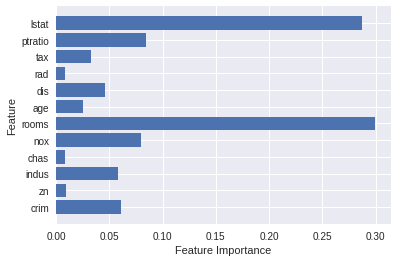

In [222]:
plot_feature_importance(house)